In [45]:
%%capture --no-stderr
%pip install -U langgraph langsmith

In [2]:
import getpass
import os
from dotenv import load_dotenv
# Load environment variables
import openai
from typing import Annotated

from sqlalchemy import create_engine
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langchain_core.messages import AIMessage, ToolMessage

from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import operator
import os
import csv
import openai
import re
import networkx as nx
from typing import Annotated, Any, List, Dict, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
import pandas as pd
# Set up OpenAI API key
import json

import sys
sys.path.append('/Users/philipnartschik/AIData/backend/app')
from config import Config
#from app.config import Config
load_dotenv()

# Set up OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')

#check if the engine is working



In [3]:
import time
from sqlalchemy import text


engine = create_engine(Config.SQLALCHEMY_DATABASE_URI)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model='gpt-4o-mini',max_tokens=1000, temperature=0.0, n=1, stop=None)

llmgen = ChatOpenAI(model='gpt-4o',max_tokens=1000, temperature=0.0, n=1, stop=None)

llm_with_tools = llm.bind_tools(tools)
llmgen_with_tools = llmgen.bind_tools(tools)
# Define the state schema with scripts and table_info fields
from typing import Dict

class State(TypedDict):
    scripts: Annotated[Dict[str, str], operator.or_]
    table_info: Annotated[Dict[str, dict], operator.or_]
    execution_order: List[str]
    error_messages: Annotated[List[str], operator.add]
    ask_human: bool
    table_schemas: Annotated[List[dict], operator.add]
    table_foreign_keys: Dict[str, List[Dict[str, str]]]
    cycles: List[List[str]]
    foreign_keys: List[Dict[str, str]]
    excluded_columns: List[str]


class ParallelNode:
    def __init__(self, base_name: str, file_list: List[str], folder_path: str):
        self.base_name = base_name
        self.file_list = file_list  # List of CSV files to process
        self.folder_path = folder_path

    def __call__(self, state: State) -> Any:
        try:
            # Process only the first CSV file in the group
            filename = self.file_list[0]
            file_path = os.path.join(self.folder_path, filename)
            # Read CSV using pandas
            df = pd.read_csv(file_path, nrows=1000, delimiter=";")  # Read first 1000 rows for better sampling
            if df.empty:
                error_message = f"No data found in file '{filename}' for table '{self.base_name}'"
                if len(self.file_list) > 1:
                    filename = self.file_list[1]
                    file_path = os.path.join(self.folder_path, filename)
                    df = pd.read_csv(file_path, nrows=1000)
                else:
                    return {
                        "error_messages": [error_message],
                    }
            # Get column data types
            column_types = df.dtypes.apply(lambda x: str(x)).to_dict()
            # Collect sample data and unique values for each column
            sample_data = df.head(3).to_dict(orient='records')
            unique_values_count = df.nunique().to_dict()
            # Prepare column information
            columns_info = {}
            for col in df.columns:
                columns_info[col] = {
                    'data_type': column_types[col],
                    'unique_values_count': unique_values_count[col],
                    'sample_values': df[col].head(3).dropna().astype(str).tolist()
                }
            # Extract just the column names
            column_names = list(df.columns)
            # Return the table schema to the supervisor
            table_schema = {
                "table_name": self.base_name,
                "columns": column_names,        # Only column names
                "columns_info": columns_info,   # Detailed info stored separately
            }
            print(f"Node processing table '{self.base_name}' extracted schema.")
            return {
                "table_schemas": [table_schema],
                # Return the updated known_tables
                "known_tables": [self.base_name],  # Return only the new table to be added
            }
        except Exception as e:
            # Handle exceptions and set flag to ask for human assistance
            error_message = f"Error in node '{self.base_name}': {str(e)}"
            print(error_message)
            return {
                "error_messages": [error_message]
            }

class GenerateScriptNode:
    def __init__(self, base_name: str):
        self.base_name = base_name
        # Local messages list for conversation history
        self.messages = []
    
    def __call__(self, state: State) -> Any:
        try:
            table_schemas = state.get("table_schemas", [])
            table_foreign_keys = state.get("table_foreign_keys", {})
            known_tables = []
            for schema in table_schemas:
                if schema['table_name'] not in known_tables:
                    known_tables.append(schema['table_name'])
            # Find the schema for this table
            schema = next((s for s in table_schemas if s['table_name'] == self.base_name), None)
            if schema is None:
                error_message = f"Schema not found for table '{self.base_name}'"
                print(error_message)
                return {"error_messages": [error_message]}
            columns_info = schema.get('columns_info', {})
            # Reconstruct 'columns' as a dict mapping column names to data types
            columns = {col_name: col_info['data_type'] for col_name, col_info in columns_info.items()}
            foreign_keys = table_foreign_keys.get(self.base_name, [])
            # Prepare prompt with columns and foreign keys
            prompt = self.prepare_prompt(columns, foreign_keys, known_tables)
            # Call LLM to generate SQL script
            script = self.call_llm(prompt)
            # Extract primary keys and foreign keys from the script
            table_info = self.extract_keys(script)
            table_info['table_name'] = self.base_name
            return {
                "scripts": {self.base_name: script},
                "table_info": {self.base_name: table_info},
            }
        except Exception as e:
            error_message = f"Error generating script for table '{self.base_name}': {str(e)}"
            print(error_message)
            return {
                "error_messages": [error_message],
            }
    
    def prepare_prompt(self, columns: Dict[str, str], foreign_keys: List[Dict[str, str]], known_tables: List[str]) -> str:
        # Construct the prompt
        prompt = (
            f"Using the following table schema, generate a SQL CREATE TABLE script for a table named '{self.base_name}'. "
            f"Include appropriate data types, primary keys, and foreign key constraints. "
            f"Use double quotes around table and column names to preserve case sensitivity."
            f"Do not reference tables other than '{', '.join(known_tables)}'.\n\n"
            f"Columns and data types:\n"
        )
        for col_name, col_type in columns.items():
            prompt += f"- {col_name}: {col_type}\n"
        if foreign_keys:
            prompt += "\nForeign key relationships:\n"
            for fk in foreign_keys:
                prompt += (
                    f"- {fk['c']} references {fk['ref']}({fk['ref_c']})\n"
                )
        else:
            prompt += "\nNo foreign keys.\n"
        prompt += "\nPlease provide the syntactically correct SQL script that is runnable out of the box. Start without ```sql"
        return prompt

    def call_llm(self, prompt: str) -> str:
        # Initialize the LLM
        # Prepare messages
        try:
            self.messages = []
            self.messages.append({"role": "system", "content": "You are an expert SQL database designer."})
            self.messages.append({"role": "user", "content": prompt})
            # Invoke the LLM
            response = llmgen_with_tools.invoke(self.messages)
        except Exception as e:
            # Handle rate limit error
            print("Rate limit error. Waiting for 5 minutes...")
            time.sleep(10)
            response = llm_with_tools.invoke(self.messages)
        # Update messages with the response
        self.messages.append(response)
        # Extract the content
        script = response.content.strip()
        return script

    def extract_keys(self, script: str) -> Dict[str, List[str]]:
        # Simple parsing of SQL script to extract primary and foreign keys
        primary_keys = []
        foreign_keys = []
        # Use regex to find PRIMARY KEY and FOREIGN KEY constraints
        pk_match = re.search(r'PRIMARY KEY\s*\((.*?)\)', script, re.IGNORECASE | re.DOTALL)
        if pk_match:
            pk_fields = pk_match.group(1)
            primary_keys = [field.strip(' `') for field in pk_fields.split(',')]
        fk_matches = re.findall(
            r'FOREIGN KEY\s*\((.*?)\)\s*REFERENCES\s*`?(\w+)`?\s*\((.*?)\)',
            script, re.IGNORECASE | re.DOTALL
        )
        for fk_field, ref_table, ref_field in fk_matches:
            foreign_keys.append(ref_table)
        return {'primary_keys': primary_keys, 'foreign_keys': foreign_keys}
    
def human_exclude_node(state: State) -> Any:
    table_schemas = state.get("table_schemas", [])
    # Collect all columns and their occurrences
    column_info = {}
    for schema in table_schemas:
        table_name = schema['table_name']
        columns_info = schema['columns_info']  # Access 'columns_info' for detailed info
        for col_name, col_info in columns_info.items():
            if col_name not in column_info:
                column_info[col_name] = {
                    'occurrence': 0,
                    'data_types': set(),
                    'sample_values': [],
                    'unique_values_counts': [],
                    'tables': set()
                }
            column_info[col_name]['occurrence'] += 1
            column_info[col_name]['data_types'].add(col_info['data_type'])
            column_info[col_name]['tables'].add(table_name)
            column_info[col_name]['unique_values_counts'].append(col_info['unique_values_count'])
            if len(column_info[col_name]['sample_values']) < 3:
                column_info[col_name]['sample_values'].extend(col_info['sample_values'])
                # Ensure we don't have more than 3 sample values
                column_info[col_name]['sample_values'] = column_info[col_name]['sample_values'][:3]
    # Now, present the columns to the user
    print("Columns candidates for exclusion:")
    columns_sorted = sorted(column_info.items(), key=lambda x: x[1]['occurrence'], reverse=True)
    for idx, (col_name, info) in enumerate(columns_sorted):
        avg_unique_values = sum(info['unique_values_counts']) / len(info['unique_values_counts'])
        if avg_unique_values < 20 and info['occurrence'] >= 2:
            print(f"{idx}: Column '{col_name}'")
            print(f"    Occurs in {info['occurrence']} tables: {', '.join(info['tables'])}")
            print(f"    Data types: {', '.join(info['data_types'])}")
            print(f"    Average number of unique values: {avg_unique_values}")
            print(f"    Sample values: {info['sample_values']}")
            print()
    # Ask the user to select columns to exclude
    print("Enter the indices of the columns to exclude from foreign key inference (separated by commas).")
    user_input = input("Indices to exclude (e.g., 0,2): ")
    indices_to_exclude = [int(idx.strip()) for idx in user_input.split(",") if idx.strip().isdigit()]
    # Build the list of excluded columns
    print("Indices to exclude:", indices_to_exclude)
    excluded_columns = [columns_sorted[idx][0] for idx in indices_to_exclude]
    print("Excluded columns:", excluded_columns)
    # Update the state
    return {
        "excluded_columns": excluded_columns,  # Return the list of excluded columns
        "ask_human": False,
    }


def call_llm_for_foreign_keys(state: State) -> any:
    # Initialize the LLM
    table_schemas = state.get("table_schemas", [])
    user_context = "The tables are standard SAP tables and columns, and the data types are consistent with SAP data types. Use your knowledge of SAP tables to infer the foreign key relationships."
    known_tables = []
    for schema in table_schemas:
        if schema['table_name'] not in known_tables:
            known_tables.append(schema['table_name'])
    excluded_columns = state.get("excluded_columns", [])
    print("The excluded columns are: ", excluded_columns)
    # Prepare schema JSON
    schema_json = {}
    for schema in table_schemas:
        table_name = schema['table_name']
        columns = schema['columns']  # This is now a list of column names
        schema_json[table_name] = columns
    # Convert schema to compact JSON string
    schema_str = json.dumps(schema_json, separators=(',', ':'))
    # Prepare prompt for LLM
    prompt = (
        f"Given the following database schema in JSON format, identify the foreign key relationships "
        f"between tables based on matching column names and data types. "
        f"The following context is provided to help you infer foreign keys: {user_context}. "
        f"Important: The following are columns that are not foreign keys: {', '.join(excluded_columns)}. "
        f"Provide the result only as a list of foreign key relationships in the format:\n"
        f"[\n"
        f"  {{'t': 'TableName', 'c': 'ColumnName', 'ref': 'ReferencedTable', 'ref_c': 'ReferencedColumn'}}\n"
        f"]\n\n"
        f"The output should be directly parsable as JSON. Not even ```json at beginning\n\n"
        f"Schema JSON:\n{schema_str}\n"
        f"Avoid redundant or repetitive foreign key relationships. Do not include multiple foreign keys between the same pair of tables unless necessary."
    )
    # Prepare messages
    messages = [{"role": "system", "content": "You are an expert database analyst. You produce executable JSONs. Please provide at most 3 foreign key relationships per table, selecting the most significant ones."},
                {"role": "user", "content": prompt}]
    # Invoke the LLM
    response = llm_with_tools.invoke(messages, max_tokens=4000)
    print("LLM response:", response.content)
    # Extract the foreign key relationships from the response
    # Assuming the response is a JSON string
    try:
        state["foreign_keys"] = json.loads(response.content)
        return 
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        foreign_keys = input("Enter the foreign key relationships as a JSON list: ")
        state["foreign_keys"] = json.loads(foreign_keys)
        return 


def supervisor(state: State) -> Any:
    table_schemas = state.get("table_schemas", [])
    foreign_keys = state.get("foreign_keys", [])
    known_tables = []
    for schema in table_schemas:
        if schema['table_name'] not in known_tables:
            known_tables.append(schema['table_name'])
    # Prepare schema JSON
    schema_json = {}
    for schema in table_schemas:
        table_name = schema['table_name']
        columns = schema['columns']  # This is now a list of column names
        schema_json[table_name] = columns
    print("Inferred foreign keys:", foreign_keys)
    # Build dependency graph
    G = nx.DiGraph()
    for table in known_tables:
        G.add_node(table)
    for fk in foreign_keys:
        if fk['ref'] in known_tables:
            G.add_edge(fk['ref'], fk['t'])
    # Perform topological sort
    try:
        execution_order = list(nx.topological_sort(G))
        print("Determined execution order:", execution_order)
        # Distribute foreign key information back to tables
        table_foreign_keys = {table_name: [] for table_name in known_tables}
        for fk in foreign_keys:
            table_foreign_keys[fk['t']].append(fk)
        # Update the state
        return {
            "table_foreign_keys": table_foreign_keys,
            "execution_order": execution_order,
            "table_schemas": table_schemas,
            # Optionally have a user check the foreign keys
        }
    except nx.NetworkXUnfeasible:
        # Cyclic dependency detected
        error_message = "Error: Cyclic dependency detected in foreign keys."
        print(error_message)
        # Find cycles in the graph
        cycles = list(nx.simple_cycles(G))
        print("Detected cycles:", cycles)
        # Update state with cycles and ask for human intervention
        return {
            "error_messages": [error_message],
            "cycles": cycles,
            "foreign_keys": foreign_keys,
            "table_schemas": table_schemas,
            "ask_human": True,
        }


def final_node(state: State) -> Any:
    scripts = state.get("scripts", {})
    table_infos = state.get("table_info", {})
    execution_order = state.get("execution_order", [])
    print("Executing scripts in the following order:")
    for table_name in execution_order:
        script = scripts[table_name]
        print(f"Executing script for table '{table_name}':\n{script}\n")
        try:
            with engine.connect() as connection:
                #catch the result of the execution
                connection.begin()
                result = connection.execute(text(script))
                connection.commit()
                print(f"Table '{table_name}' created successfully. {result}\n")
        except Exception as e:
            print(f"Error executing SQL script for table '{table_name}': {e}")
    return state


def human_intervention_condition(state: State, **kwargs):
    if state.get("ask_human", False):
        # Return the name of the next node(s) to execute
        return ["human"]
    else:
        # Proceed to the next nodes (e.g., script generation nodes)
        return []


def human_node(state: State) -> Any:
    error_messages = state.get("error_messages", [])
    cycles = state.get("cycles", [])
    foreign_keys = state.get("foreign_keys", [])
    table_schemas = state.get("table_schemas", [])
    known_tables = []
    for schema in table_schemas:
        if schema['table_name'] not in known_tables:
            known_tables.append(schema['table_name'])
    print("Human intervention required.")
    for message in error_messages:
        print(f"Error: {message}")
    if cycles:
        print("\nDetected cyclic dependencies in the foreign key relationships:")
        for cycle in cycles:
            print(" -> ".join(cycle))
    # Present the foreign keys causing the cycles
    print("\nForeign key relationships:")
    for i, fk in enumerate(foreign_keys):
        print(f"{i}: {fk['t']}.{fk['c']} -> {fk['ref']}.{fk['ref_c']}")
    # Ask the human to remove or modify foreign keys to resolve the cycles
    print("\nPlease review the foreign key relationships and specify any to remove to resolve the cycles.")
    print("Enter the indices of the foreign keys to remove (separated by commas).")
    user_input = input("Indices to remove (e.g., 0,2): ")
    indices_to_remove = [int(idx.strip()) for idx in user_input.split(",") if idx.strip().isdigit()]
    # Remove the specified foreign keys
    modified_foreign_keys = [fk for i, fk in enumerate(foreign_keys) if i not in indices_to_remove]
    # Rebuild the dependency graph with modified foreign keys
    G = nx.DiGraph()
    for table in known_tables:
        G.add_node(table)
    for fk in modified_foreign_keys:
        if fk['ref'] in known_tables:
            G.add_edge(fk['ref'], fk['t'])
    try:
        execution_order = list(nx.topological_sort(G))
        print("\nNew execution order after modifications:", execution_order)
        # Distribute modified foreign key information back to tables
        table_foreign_keys = {table_name: [] for table_name in known_tables}
        for fk in modified_foreign_keys:
            table_foreign_keys[fk['t']].append(fk)
        # Update the state
        return {
            "table_foreign_keys": table_foreign_keys,
            "execution_order": execution_order,
            "table_schemas": table_schemas,
            "error_messages": [],
            "ask_human": False,
        }
    except nx.NetworkXUnfeasible:
        print("Cyclic dependencies still exist after modifications.")
        # Update state to indicate that human intervention is still required
        return {
            "error_messages": ["Cyclic dependencies still exist after human intervention."],
            "ask_human": True,
            "cycles": list(nx.simple_cycles(G)),
            "foreign_keys": modified_foreign_keys,
            "table_schemas": table_schemas,
        }

def select_next_node(state: State) -> str:
    if state.get("ask_human", False):
        return "human"
    elif "execution_order" in state and state["execution_order"]:
        return "generate_scripts"
    else:
        return "supervisor"

# Function to group CSV files by base name
def group_csv_files(folder_path: str) -> Dict[str, List[str]]:
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    groups = {}
    for filename in csv_files:
        # Extract base name; e.g., for 'bse_1.csv' or 'bse_2.csv', base name is 'bse'
        base_name = filename.split('_')[0]
        if base_name not in groups:
            groups[base_name] = []
        groups[base_name].append(filename)
    return groups

def generate_scripts_node(state: State) -> Any:
    return state


# Provide the folder path
folder_path = '/Users/philipnartschik/Downloads/Demo'  # Replace with your actual folder path

# Group CSV files by base name
csv_groups = group_csv_files(folder_path)
# For testing, only have 4 csv_groups
csv_groups = {k: csv_groups[k] for k in list(csv_groups)[:4]}

# Initialize the graph
builder = StateGraph(State)

# Add the initial node
builder.add_node("initial", lambda state: state)
builder.add_edge(START, "initial")

# Dynamically add parallel nodes based on the number of base names
for base_name, file_list in csv_groups.items():
    node_name = f"parallel_{base_name}"
    builder.add_node(node_name, ParallelNode(base_name, file_list, folder_path))
    builder.add_edge("initial", node_name)
    # Edge to supervisor
    builder.add_edge(node_name, "human_exclude")

# Add the human_exclude_node
builder.add_node("human_exclude", human_exclude_node)

builder.add_node("callforkeys", call_llm_for_foreign_keys)
# Edge from human_exclude_node to supervisor
builder.add_edge("human_exclude", "callforkeys")


builder.add_edge("callforkeys", "supervisor")

# Add the supervisor node
builder.add_node("supervisor", supervisor)
builder.add_conditional_edges("supervisor", 
                              select_next_node,
                              {"human": "human", "generate_scripts": "generate_scripts", "supervisor": "supervisor"},)

# Add the human node
builder.add_node("human", human_node)
builder.add_edge("human", "supervisor")

builder.add_node("generate_scripts", generate_scripts_node)

# Add the generate_script nodes
for base_name in csv_groups.keys():
    node_name = f"generate_{base_name}"
    builder.add_node(node_name, GenerateScriptNode(base_name))
    builder.add_edge("generate_scripts", node_name)
    builder.add_edge(node_name, "final")

# Add the final node
builder.add_node("final", final_node)
builder.add_edge("final", END)


# Compile the graph
memory = MemorySaver()
graph = builder.compile(
#    checkpointer=memory,
)

# Execute the graph with the initial state
initial_state = {
    "scripts": {},           # Changed from [] to {}
    "table_info": {},        # Changed from [] to {}
    "execution_order": [],
    "error_messages": [],
    "ask_human": False,
    "table_schemas": [],     # Ensure this is included if used
    "excluded_columns": [],
}
graph.invoke(initial_state)

#0,3,7,14,15,18,20,31,33,40,72




Node processing table 'T16FG' extracted schema.
Node processing table 'LFA1' extracted schema.
Node processing table 'BKPF' extracted schema.
Node processing table 'BSEG' extracted schema.
Columns candidates for exclusion:
0: Column 'MANDT'
    Occurs in 4 tables: BSEG, T16FG, BKPF, LFA1
    Data types: int64
    Average number of unique values: 1.0
    Sample values: ['400', '400', '400']

2: Column 'BUKRS'
    Occurs in 2 tables: BSEG, BKPF
    Data types: object
    Average number of unique values: 6.0
    Sample values: ['1710', '1710', '1710']

3: Column 'GJAHR'
    Occurs in 2 tables: BSEG, BKPF
    Data types: int64
    Average number of unique values: 1.0
    Sample values: ['2024', '2024', '2024']

Enter the indices of the columns to exclude from foreign key inference (separated by commas).
Indices to exclude: [0, 2, 3]
Excluded columns: ['MANDT', 'BUKRS', 'GJAHR']
The excluded columns are:  ['MANDT', 'BUKRS', 'GJAHR']
LLM response: [
  {"t": "BKPF", "c": "BELNR", "ref": "BSEG

{'scripts': {'BKPF': 'CREATE TABLE "BKPF" (\n    "AEDAT" FLOAT,\n    "AWKEY" BIGINT,\n    "AWTYP" VARCHAR,\n    "BELNR" BIGINT,\n    "BLART" VARCHAR,\n    "BLDAT" BIGINT,\n    "BSTAT" VARCHAR,\n    "BUDAT" BIGINT,\n    "BUKRS" VARCHAR,\n    "CPUDT" BIGINT,\n    "CPUTM" BIGINT,\n    "DBBLG" FLOAT,\n    "GJAHR" BIGINT,\n    "HWAER" VARCHAR,\n    "KURSF" FLOAT,\n    "MANDT" BIGINT,\n    "MONAT" BIGINT,\n    "PPDAT" FLOAT,\n    "PPNAM" VARCHAR,\n    "PPTCOD" FLOAT,\n    "PPTME" BIGINT,\n    "REINDAT" FLOAT,\n    "STBLG" FLOAT,\n    "STGRD" FLOAT,\n    "STJAH" BIGINT,\n    "TCODE" VARCHAR,\n    "UPDDT" FLOAT,\n    "USNAM" VARCHAR,\n    "WAERS" VARCHAR,\n    "WWERT" BIGINT,\n    "XREVERSAL" FLOAT,\n    PRIMARY KEY ("BELNR", "GJAHR", "BUKRS")\n);',
  'BSEG': 'CREATE TABLE "BSEG" (\n    "AUGBL" FLOAT,\n    "AUGCP" FLOAT,\n    "AUGDT" FLOAT,\n    "AUGGJ" BIGINT,\n    "BELNR" BIGINT,\n    "BSCHL" BIGINT,\n    "BUKRS" VARCHAR,\n    "BUZEI" BIGINT,\n    "BUZID" FLOAT,\n    "DMBTR" FLOAT,\n    "GJA

In [ ]:
final_node

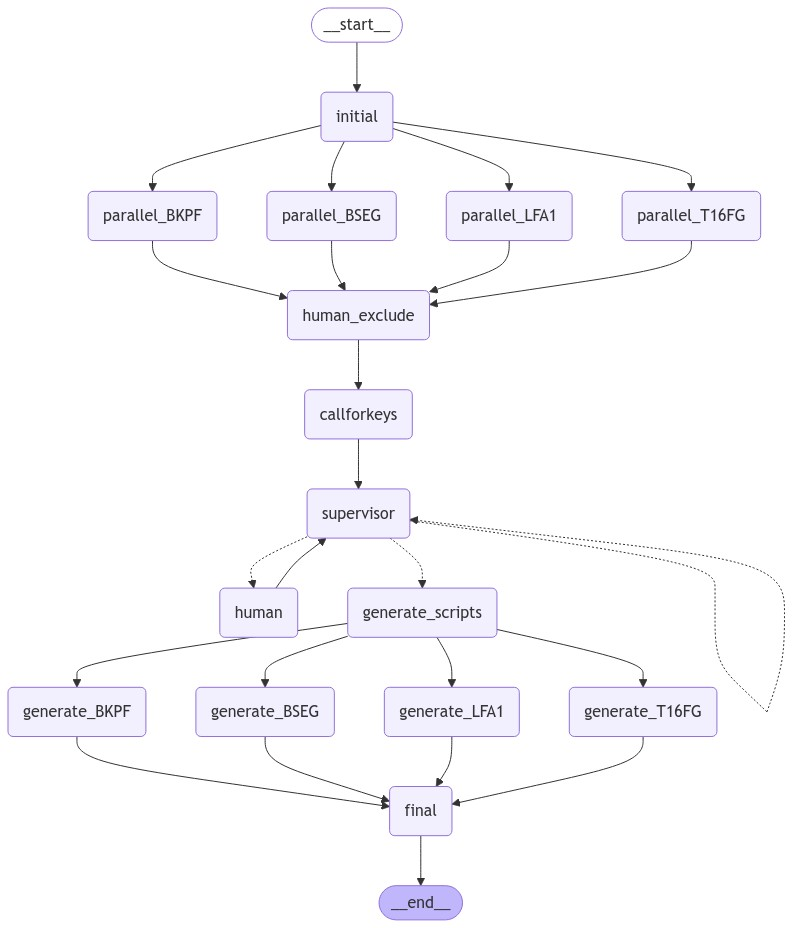

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "1"}}